Before we begin, we will change a few settings to make the notebook look a bit prettier

In [1]:
%%html
<style> body {font-family: "Calibri", cursive, sans-serif;} </style>

<img src="https://iknl.nl/images/default-source/images/.png?sfvrsn=3" align="right">

# Understanding VERTIGO
In this notebook we provide a step-by-step explanation of how VERTIGO works and how we implemented them. 

For ease of use, you can find an object version of VERTIGO in [`vertigo.py`](./vertigo.py). For a (simulated) distributed scenario where we actually use it, see the notebook [`demo_vertigo_local`](./demo_vertigo_local.py). For a real-life distributed implementation of VERTIGO using our [privacy preserving DL infrastructure](https://github.com/IKNL/ppDLI), see our repository, `d_vertigo`.

All right. Let's get started.

## Preliminaries
Display plots.

In [2]:
%matplotlib inline

Import packages

In [3]:
import sys
import os
import pathlib
import pandas as pd
import numpy as np
import numpy.matlib as npm
import seaborn as sns
import warnings
import matplotlib as mpl
from matplotlib import pyplot as plt
import statsmodels as sm
from sklearn.model_selection import train_test_split

import auxiliaries

Set (default) plotting parameters.

In [4]:
mpl.rcParams['font.sans-serif'] = "Calibri"
mpl.rcParams['font.family'] = "sans-serif"
sns.set(font_scale=1.75)
sns.set_style('ticks')
plt.rc('axes.spines', top=False, right=False)

Setup paths.

In [5]:
# Setup working path
os.chdir(os.getcwd())

PATH_DATA = pathlib.Path(r'../data/')
PATH_RESULTS = pathlib.Path(r'../results/')

if not PATH_DATA.exists():
    raise ValueError("Data directory not found.")
    
if not PATH_RESULTS.exists():
    path_results.mkdir()

Setup execution parameters.

In [6]:
# Test/train partitioning.
TEST_PROP = 0.2
SEED = 31416 # For reproducibility.


# VERTIGO execution parameters.
LAMBDA_ = np.array([1000])
TOLERANCE = 1e-8
ITERATIONS = 500

# We know alpha needs to be bounded between 0 and 1 (see Fig. 4, 3.ii).
# Thus we will initialize it at 0.5.
ALPHA_INIT_VAL = 0.5 

## The data
We will be using the [Breast Cancer Wisconsin Diagnostic Data Set](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29). The data consists of real-valued features computed from a digitalized image of breast biposy. The features describe the characteristics of the cell nuclei present in the image: 
* `radius` - mean of distances from center to points on the perimeter
* `texture` - standard deviation of gray-scale values
* `perimeter`
* `area`
* `smoothness` - local variation in radii lengths
* `compactness` - perimeter^2 / area - 1.0
* `concavity` - severity of concave portions of the contour
* `concave points` - number of concave portions of the contour
* `symmetry`
* `fractal dimension` - "coastline approximation" - 1

The mean, standard error, and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For the sake of simplicity, we will only consider the mean values of the features, resulting in 10 features. The output variable is `diagnosis`, which states if result of the biopsy was a benign (`B`) or a malignant (`M`) tumor.

In [7]:
df = pd.read_csv(PATH_DATA/'data.csv', index_col=0, usecols=range(0, 12))
df.head(5)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
id,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


Notice how in this case, all variables are continuous. If the data had categorical values, they would need to be encoded, preferably using [one-hot encoding](https://en.wikipedia.org/wiki/One-hot).

## Data pre-processing
Extract the features only

In [8]:
column_names = list(df.columns)[1:]
X_centralized = df[column_names]

In order to avoid having features that are dominant just because of their range, we will normalize them.

In [9]:
X_centralized = (X_centralized - np.min(X_centralized))/(np.max(X_centralized) - np.min(X_centralized))

### Re-structuring of the data
For the sake of this example, we will simulate two different parties. Each of these parties will have half of the features.

In [10]:
X1 = X_centralized[column_names[0:round(len(column_names)/2)]]
X1.head(5)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean
id,,,,,
842302,0.521037,0.022658,0.545989,0.363733,0.593753
842517,0.643144,0.272574,0.615783,0.501591,0.289880
84300903,0.601496,0.390260,0.595743,0.449417,0.514309
84348301,0.210090,0.360839,0.233501,0.102906,0.811321
84358402,0.629893,0.156578,0.630986,0.489290,0.430351


In [11]:
X2 = X_centralized[column_names[round(len(column_names)/2):]]
X2.head(5)

,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
id,,,,,
842302,0.792037,0.703140,0.731113,0.686364,0.605518
842517,0.181768,0.203608,0.348757,0.379798,0.141323
84300903,0.431017,0.462512,0.635686,0.509596,0.211247
84348301,0.811361,0.565604,0.522863,0.776263,1.000000
84358402,0.347893,0.463918,0.518390,0.378283,0.186816


### Output
VERTIGO uses an output of -1 or 1.

In [12]:
y = df[['diagnosis']]
y = y['diagnosis'].map(lambda x: 1 if x=='M' else -1)
y = pd.DataFrame(y)

## Class balancing
This is particularly important for any logistic regression, including VERTIGO. If a class is underrepresented, the model will apparently perform well, but it will likely just predict one class all the time. Thus we need to balance it. We will do so using downsampling.

In [13]:
X1_balanced, y_balanced = auxiliaries.downsample(X1, y, random_state=0)
X2_balanced, _ = auxiliaries.downsample(X2, y, random_state=0)

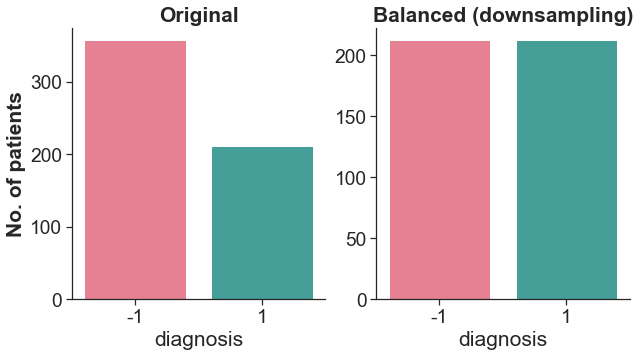

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10, 5])
sns.countplot(x='diagnosis', data=y, palette='husl', ax=ax1)
sns.countplot(x='diagnosis', data=y_balanced, palette='husl', ax=ax2)
ax1.set_title("Original", weight='bold')
ax2.set_title("Balanced (downsampling)", weight='bold')
ax1.set_ylabel("No. of patients", weight='bold')
ax2.set_ylabel("")
fig.savefig(PATH_RESULTS/('class_proportion.pdf'), dpi=1000, bbox_inches='tight')
plt.show();

## Data partition
Partition data into training and testing sets.

In [15]:
X1_train, X1_test, y_train, y_test = train_test_split(X1_balanced, y_balanced, test_size=TEST_PROP, random_state=SEED)
X2_train, X2_test, _, _ = train_test_split(X2_balanced, y_balanced, test_size=TEST_PROP, random_state=SEED)

## VERTIGO
### 0. Preparations
Before actually computing VERTIGO, we need to do a few things. These steps are shown here for didactic purposes. **Notice that the object `vertigo.vertigo` already does them internally**. 

First, we need to convert DataFrames to numpy arrays (for mathematical operations). Furthermore, we will rename the variables to match the paper's notation.

In [16]:
X1 = X1_train.to_numpy()
X2 = X2_train.to_numpy()

Y = y_train.to_numpy()
Y_diag = np.diag(Y.flatten())

Add column of 1s to serve as constant term in the computation of the residual coefficient.

In [17]:
X1 = sm.tools.add_constant(X1, prepend=False)
X2 = sm.tools.add_constant(X2, prepend=False)

Compute some variables for ease of use.

In [18]:
M = X1.shape[0] # Number of patients (same for both parties).
N1 = X1.shape[1] # Number of party 1's features.
N2 = X2.shape[1] # Number of party 2's features.

Initialize alpha.

In [19]:
ALPHA_INIT = ALPHA_INIT_VAL * np.ones((M, 1))

Lastly, we will define a few useful functions. These are also part of `vertigo.vertigo` methods

In [20]:
# Check if matrix is diagonally dominant.
def is_diagonally_dominant(X):
    D = np.diag(np.abs(X)) # Find diagonal coefficients
    S = np.sum(np.abs(X), axis=1) - D # Find row sum without diagonal
    if np.all(D > S):
        return True
    else:
        return False

# Check if matrix is positive definite.
def is_positive_definite(x):
    return np.all(np.linalg.eigvals(x) > 0)

# Sigmoid function to bound a number between 0 and 1
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

### 1. Local

#### 1.1 Compute local gram matrix (i.e., linear kernel matrix)

In [21]:
K1 = np.matmul(X1, X1.T)
K2 = np.matmul(X2, X2.T)

### 2. Server
#### 2.1 Compute global gram matrix $K$

In [22]:
K = np.add(K1, K2)

#### 2.2 Compute fixed Hessian matrix $\tilde{H}$(Eq. 10)
Originally, the paper states that $c$ must be set to a value that makes $\tilde{H}$ diagonally dominant. We initialize it as "the maximum of the elements in the original $H$" (p. 573). Then, we increase $c$ by a factor in steps of 0.5 until the condition of diagonally dominance is satisfied.

However, in our experiments we didn't find this condition to be necessary, getting the same results if we adjusted $c$ or not. We give the option to the user to do so (see line 14). 

Depending on the data, computing  $\tilde{H}$ can take quite long.

In [23]:
not_diagonally_dominant = True
c_factor = 1

while not_diagonally_dominant:

    H = (1/LAMBDA_) * np.matmul(np.matmul(Y_diag, K), Y_diag) + np.diag(1/(ALPHA_INIT*(1-ALPHA_INIT)))
    c =  c_factor * H.max()
    I = np.identity(len(Y_diag))

    H_wave = (1/LAMBDA_) * np.matmul(np.matmul(Y_diag, K), Y_diag) + c*I
    not_diagonally_dominant = not is_diagonally_dominant(H_wave)
    c_factor += 0.5

    # Comment break to make sure that H_wave is diagonally dominant.
    break

#### 2.3 Compute $\tilde{H}^{-1}$

In [24]:
H_wave_1 = np.linalg.inv(H_wave)

### 3. Local + server
Compute $\alpha*$

In [25]:
# We will store the evolution of the alpha coefficients here.
alpha_all = np.zeros((Y.shape[0], ITERATIONS))

for s in range(0, ITERATIONS):

    if s==0:
        alpha_old = ALPHA_INIT 
    else:
        alpha_old = alpha

    alpha_all[:, s] = alpha_old.T
    

    # 3.1 LOCAL
    # Eq. 5
    beta1 = (1/LAMBDA_) * np.sum((npm.repmat(alpha_old, 1, N1) * 
                               npm.repmat(Y, 1, N1) *
                               X1), 0)
    beta2 = (1/LAMBDA_) * np.sum((npm.repmat(alpha_old, 1, N2) * 
                               npm.repmat(Y, 1, N2) *
                               X2), 0)

    # In order for the matrix multiplications to work, Y needs to be
    # transposed (which is not stated in the paper).
    E1 = Y.T * (np.matmul(beta1, X1.T))
    E2 = Y.T * (np.matmul(beta2, X2.T))


    # 3.2 SERVER
    E = E1 + E2

    # Catch incorrect cases (logarithm of a negative number)
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            J = E.T + np.log10(alpha_old/(1-alpha_old))
        except Warning as e:
            print('WARNING:', e)

            
    # 3.3 SERVER
    # Update alpha.
    alpha = alpha_old - np.matmul(H_wave_1, J)

    # Bound alpha (0 < alpha < 1)
    # This isn't defined in the original paper, but is done to avoid
    # problems when computing J (the logarithm of a negative number is
    # undefined).
    alpha = sigmoid(alpha)

    # Check for convergence.
    if max(abs(alpha - alpha_old)) < TOLERANCE:
        # Trim alpha_all.
        alpha_all = np.delete(alpha_all, np.s_[s:], axis=1)
        break

# Final alpha value.
alpha_star = alpha

### 4. Local
Compute the $\beta$ coefficients (and the intercept). This step isn't defined in Fig. 4, but it is the logical next step

In [26]:
coeffs1 = (1/LAMBDA_) * np.sum((npm.repmat(alpha_star, 1, N1) * 
                           npm.repmat(Y, 1, N1) *
                           X1[:, :]), 0)
coeffs2 = (1/LAMBDA_) * np.sum((npm.repmat(alpha_star, 1, N2) * 
                           npm.repmat(Y, 1, N2) *
                           X2[:, :]), 0)

beta1 = coeffs1[0:-1]
beta2 = coeffs2[0:-1]
intercept = coeffs1[-1] # Notice how the intercept is the same for both parties.

print("Party 1 coefficients are ", end='', flush=True)
print(beta1)
print("Party 2 coefficients are ", end='', flush=True)
print(beta2)
print("Intercept is ", end='', flush=True)
print(intercept)

Party 1 coefficients are [0.02656502 0.01223053 0.02735187 0.02322579 0.01138798]
Party 2 coefficients are [0.02350349 0.03031696 0.03433975 0.00996463 0.00073673]
Intercept is -0.002826607481672041


And that's it! These are the coefficients of our model. They have the same order as the input features. They can be found in a `vertigo.vertigo` object as `beta_coef_` and `intercept_`.